## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
import os, sys
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))

/Users/Tony/Other Docs/distilling-and-forgetting-in-large-pre-trained-models


In [4]:
from IPython.display import Audio, display
from typing import Tuple
from tqdm.auto import tqdm

import numpy as np
import torch
import whisper
import datasets

import matplotlib.pyplot as plt
import seaborn as sns

from evaluation.eval_dataset_name_to_dataset_group import EVAL_DATASET_NAME_TO_DATASET_GROUP

device = torch.device('mps')
sns.set_theme(context="paper", style="ticks")

## User input

## Load model

In [12]:
# Load the Whisper model
model = whisper.load_model("tiny")

## Load dataset

In [23]:
EVAL_DATASET_NAME_TO_DATASET_GROUP

{'librispeech_clean': dataloader.dataset_for_evaluation.librispeech_clean_test.LibriSpeechCleanTestSet,
 'librispeech_dummy': dataloader.dataset_for_evaluation.librispeech_dummy_dataset.LibriSpeechDummyDataset,
 'ami_validation': dataloader.dataset_for_evaluation.ami_validation.AMIValidationSet,
 'ami_validation_10h': functools.partial(<class 'dataloader.dataset_for_evaluation.ami_validation.AMIValidationSet'>, is_ami_10h=True),
 'ami': dataloader.dataset_for_evaluation.ami_test.AMITestSet,
 'ami_10h': functools.partial(<class 'dataloader.dataset_for_evaluation.ami_test.AMITestSet'>, is_ami_10h=True),
 'esb_diagnostic': dataloader.dataset_for_evaluation.esb_diagnostic_dataset.ESBDiagnosticDataset,
 'esbdc': dataloader.dataset_for_evaluation.esb_diagnostic_custom_dataset.ESBDiagnosticCustomDataset,
 'mls': dataloader.dataset_for_evaluation.mls_dataset.MLSDataset,
 'mlsdc': dataloader.dataset_for_evaluation.mls_diagnostic_dataset_custom.MLSDiagnosticDatasetCustom,
 'fab': dataloader.data

In [26]:
dataset_name = "ami"

ds = EVAL_DATASET_NAME_TO_DATASET_GROUP[dataset_name]()["ami"]

Found cached dataset ami (/Users/Tony/.cache/huggingface/datasets/edinburghcstr___ami/ihm/0.0.0/0d128d0aa8145d0f16f3d5b4da86c5d5759dbe9e8f947fda04b25edb56442bd5)


In [27]:
# Fill `list_idx_hallucination` according to previous analysis:
list_idx_hallucination = [2387, 4329, 6645, 6687, 7167, 7991, 11595]

ds_hallucinations = ds.select(indices=list_idx_hallucination)

In [29]:
results = []
references = []
list_audio = []

for sample in tqdm(ds_hallucinations, total=ds_hallucinations.num_rows):
    results.append(model.transcribe(sample["audio"]["array"].astype(np.float32),
                                    language="en",
                                    temperature=0.0,
                                    no_speech_threshold=1.0,  # disable `no_speech_threshold`
                                    condition_on_previous_text=False,
                                    word_timestamps=True))
    references.append(sample["text"].lower())
    list_audio.append(sample["audio"])

  0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
from typing import Dict, Any

def count_overlaps(result: Dict[str, Any], return_freq: bool = False):
    list_words = []
    for segment in result["segments"]:
        list_words.extend(segment["words"])
    n_words = len(list_words)
    
    n_overlaps = 0
    for w1, w2 in zip(list_words, list_words[1:]):
        if w1["start"] == w1["end"] and w1["end"] >= w2["start"]:
            n_overlaps += 1
        elif w1["end"] > w2["start"]:
            n_overlaps += 1
    
    if return_freq:
        freq_overlaps = n_overlaps / n_words
        return n_overlaps, freq_overlaps
    else:
        return n_overlaps

In [31]:
n_overlaps, freq_overlaps = count_overlaps(results[1], return_freq=True)

print(n_overlaps, freq_overlaps)

0 0.0


In [32]:
overlaps = [count_overlaps(result) for result in results]

Reference:  the um a lot of people don't get their own ch and other stuff
Prediction:   I love people thank you for the rage and on this stuff.

Number of overlaps: 1


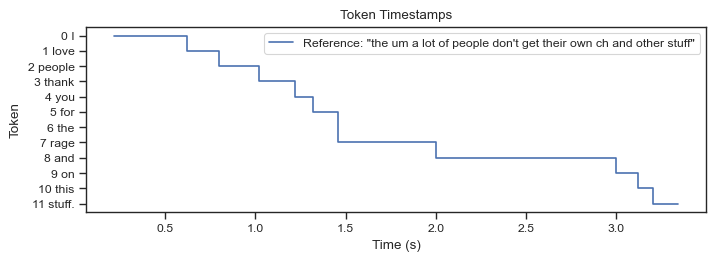

Reference:  and you must have your research proposal
Prediction:   and that you must have your research proposals.

Number of overlaps: 0


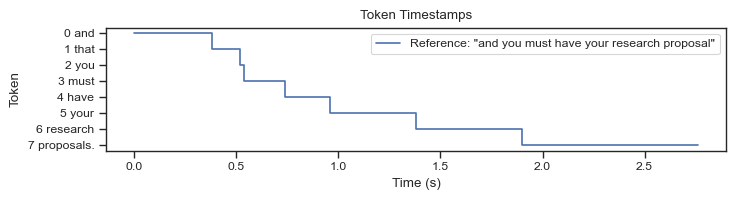

Reference:  if you if yeah if you have like buttons that appear on the screen in this l. c. d. screen
Prediction:   If you have light buttons that appear on the screen in the cell CD screen.

Number of overlaps: 0


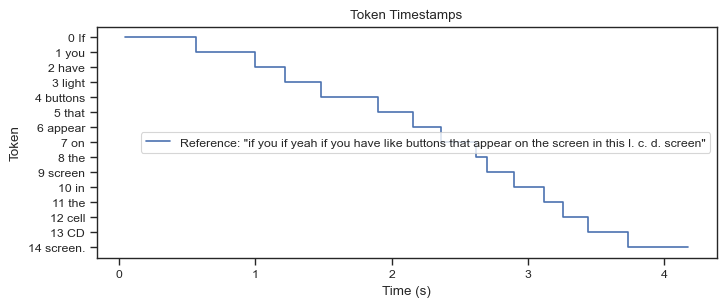

Reference:  the ju just it w well you could make it available in the titanium
Prediction:   that just, well, you could make it available in the Titanium.

Number of overlaps: 0


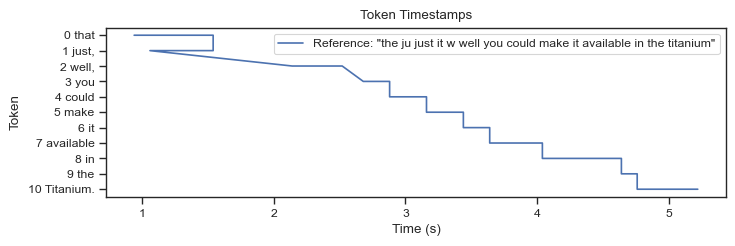

Reference:  teamwork
Prediction:   teamwork.

Number of overlaps: 0


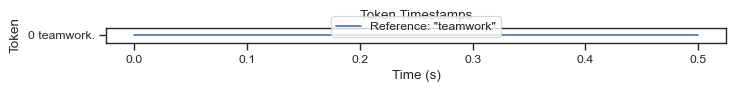

Reference:  if lost uh signal with b throw signal you know
Prediction:   if lost signal with throw signal, you know.

Number of overlaps: 0


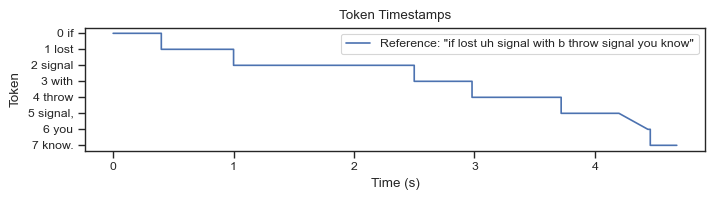

Reference:  ten
Prediction:   Thanks for watching.

Number of overlaps: 1


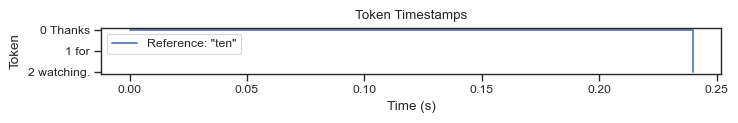

In [33]:
for audio, result, ref, n_overlaps in zip(list_audio, results, references, overlaps):
    # Load Audio player:
    display(Audio(data=audio["array"], rate=audio["sampling_rate"]))
    print
    
    # Print the transcribed text and word timestamps
    print("Reference: ", ref)
    print("Prediction: ", result["text"])
    print()
    
    # Print overlaps:
    print(f"Number of overlaps: {n_overlaps}")
     
    # Plot the token timestamps
    timestamps = []
    tokens = []
    counter = 0
    for segment in result["segments"]:
        for word in segment["words"]:
            timestamps.append(word["start"])
            timestamps.append(word["end"])
            tokens.append(str(counter) + word["word"])
            tokens.append(str(counter) + word["word"])
            counter += 1
    plt.figure(figsize=(8, len(tokens)*0.1))
    plt.plot(timestamps[::-1], tokens[::-1], label=f'Reference: "{ref}"')
    plt.legend()
    plt.xlabel("Time (s)")
    plt.ylabel("Token")
    plt.title("Token Timestamps")
    plt.show()

## Tweak the hallucination figure

In [34]:
# Fill `list_idx_hallucination` according to previous analysis:
list_idx_hallucination = [223]

ds_hallucinations = ds.select(indices=list_idx_hallucination)

In [19]:
results = []
references = []
list_audio = []

for sample in tqdm(ds_hallucinations, total=ds_hallucinations.num_rows):
    results.append(model.transcribe(sample["audio"]["array"].astype(np.float32),
                                    language="en",
                                    temperature=0.0,
                                    word_timestamps=True))
    references.append(sample["text"].lower())
    list_audio.append(sample["audio"])

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
overlaps = [count_overlaps(result) for result in results]

In [21]:
for audio, result, ref, n_overlaps in zip(list_audio, results, references, overlaps):
    # Load Audio player:
    display(Audio(data=audio["array"], rate=audio["sampling_rate"]))
    print
    
    # Print the transcribed text and word timestamps
    print("Reference: ", ref)
    print("Prediction: ", result["text"])
    print()
    
    # Print overlaps:
    print(f"Number of overlaps: {n_overlaps}")
     
    # Plot the token timestamps
    timestamps = []
    tokens = []
    counter = 0
    for segment in result["segments"]:
        for word in segment["words"]:
            timestamps.append(word["start"])
            timestamps.append(word["end"])
            tokens.append(str(counter) + word["word"])
            tokens.append(str(counter) + word["word"])
            counter += 1

Reference:  yeah
Prediction:   Yeah.

Number of overlaps: 0


In [22]:
timestamps_truncated = timestamps[:30] + [timestamps[30]] + timestamps[-40:]
tokens_truncated = tokens[:30] + ["..."] + tokens[-40:]

IndexError: list index out of range

In [ ]:
plt.figure(figsize=(12, len(tokens_truncated)*0.1))
plt.plot(timestamps_truncated[::-1], tokens_truncated[::-1], label=f'Reference: "{ref}"')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Token")
plt.title("Token Timestamps")
plt.show()

## Consider audio blocks

In [ ]:
def count_overlaps(result: Dict[str, Any], stride: float = 0.) -> int:
    counter = 0
    list_words = []
    for segment in result["segments"]:
        list_words.extend(segment["words"])
    for w1, w2 in zip(list_words, list_words[1:]):
        if w1["end"] > w2["start"] - stride:
            counter += 1
    return counter

In [ ]:
count_overlaps(result, stride=0.01)